In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Rectangle
from scipy.spatial import ConvexHull

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

def plot_ellipse(Q, center=(0, 0), scale=1):
    def normalize_matrix(A, norm_type='fro'):
        norm = np.linalg.norm(A, 'fro') if norm_type == 'fro' else np.max(np.abs(A))
        return A / norm if norm else A
    Q = normalize_matrix(Q)

    def swap_principal_axes(Q):
        eigvals, eigvecs = np.linalg.eigh(Q)
        return eigvecs @ np.diag(eigvals[::-1]) @ eigvecs.T

    Q = swap_principal_axes(Q)
    
    eigenvalues, eigenvectors = np.linalg.eigh(Q)
    if np.any(eigenvalues < 0):
        Q = np.array([[np.abs(Q[0,0]), Q[0,1]], [Q[1,0], np.abs(Q[1,1])]])

        def flip_Q_y(Q):
            F_y = np.diag([-1, 1])
            return F_y.T @ Q @ F_y

        Q = flip_Q_y(Q)

        eigenvalues, eigenvectors = np.linalg.eigh(Q)
        if np.any(eigenvalues < 0):
            return np.nan, np.nan
            
    a, b = np.sqrt(eigenvalues) * scale
    theta = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    t = np.linspace(0, 2 * np.pi, 100)
    x, y = a * np.cos(t), b * np.sin(t)
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    x_ellipse, y_ellipse = R @ np.array([x, y]) + np.array(center).reshape(2, 1)
    return x_ellipse, y_ellipse

def plot_ellipse_unmod(Q, center=(0, 0), scale=1):
    def normalize_matrix(A, norm_type='fro'):
        norm = np.linalg.norm(A, 'fro') if norm_type == 'fro' else np.max(np.abs(A))
        return A / norm if norm else A
    Q = normalize_matrix(Q)

    # def swap_principal_axes(Q):
    #     eigvals, eigvecs = np.linalg.eigh(Q)
    #     return eigvecs @ np.diag(eigvals[::-1]) @ eigvecs.T

    # q12 = -Q[0,1]

    # Q[0,1] = q12
    # Q[1,0] = q12

    if Q[0,0] < 0:
        Q = -Q

    eigenvalues, eigenvectors = np.linalg.eigh(Q)
    if np.any(eigenvalues < 0):
        return np.nan, np.nan
    a, b = np.sqrt(eigenvalues) * scale
    theta = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    t = np.linspace(0, 2 * np.pi, 100)
    x, y = a * np.cos(t), b * np.sin(t)
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    x_ellipse, y_ellipse = R @ np.array([x, y]) + np.array(center).reshape(2, 1)
    return x_ellipse, y_ellipse

In [2]:
import pickle
with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    sample_data = pickle.load(file)
the_frontier_eddies = list(sample_data.keys())

z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150,150,:]


In [3]:
def moca(u, v, x, y, n_ic, n_jc, r=20):
    
    def find_root(x, y):
        coeffs = np.polyfit(x, y, 3)
        roots = np.roots(np.poly1d(coeffs))
        real_roots = roots[np.isreal(roots)].real
        mid = x[len(x)//2]
        return real_roots[np.argmin(np.abs(mid - real_roots))]

    def tang_at_root(x, y, rx):
        coeffs = np.polyfit(x, y, 3)
        deriv = np.polyder(coeffs)
        slope = np.polyval(deriv, rx)
        intercept = np.polyval(coeffs, rx) - slope * rx
        return slope, intercept
    
    def cubic_interpolate(x, y, root):
        coeffs = np.polyfit(x, y, 3)
        return np.polyval(coeffs, root)

    u1 = u[n_ic - r:n_ic + r + 1, n_jc]

    if np.any(np.isnan(u1)):
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    
    v1 = v[n_ic - r:n_ic + r + 1, n_jc]
    xx = x[n_ic - r:n_ic + r + 1]
    base = xx[0]
    l = xx - base
    yy = np.full_like(xx, y[n_jc])
    
    root = find_root(l, v1)
    c, b = tang_at_root(l, v1, root)  # c: slope, b: intercept
    a = cubic_interpolate(l, u1, root)
    
    x0 = -b / c + base
    y0 = a / c + yy[0]
    w = 2 * c
    
    return x0, y0, l, xx, yy, u1, v1, a, b, c, w 

def fit_Rc_VN1(x1, y1, v1, q11, q12, q22, x0, y0,
           psi0_0=1.0, Rc0=1.0,
           bounds_scale=(-np.inf, np.inf), bounds_Rc=(.5, 15)):
    from scipy.optimize import minimize

    q11, q22 = np.abs(q11), np.abs(q22)

    # relative transect offset
    y_T = y1[0]

    def obj(p):
        psi0, Rc = p
        if Rc <= 0:
            return np.inf

        Q11 = - psi0 / Rc**2 * q11
        Q12 = - psi0 / Rc**2 * q12
        Q22 = - psi0 / Rc**2 * q22

        # build un‐scaled quadratic
        C = Q11
        B = -2*Q11*x0 + 2*Q12*(y_T-y0)
        E = Q11*x0**2 - 2*Q12*x0*(y_T-y0) + Q22*(y_T-y0)**2

        # modelled V_N
        expo = -(C*x1**2 + B*x1 + E) / Rc**2
        VN = -(2*C*x1 + B) / Rc**2 * np.exp(expo) * psi0

        return np.sum((v1 - VN)**2)

    p0 = np.array([psi0_0, Rc0])

    res = minimize(obj, p0,
                   bounds=[bounds_scale, bounds_Rc],
                   method='L-BFGS-B')
    if not res.success:
        raise RuntimeError("Optimization failed: " + res.message)

    return res.x  # scale_opt, Rc_opt

def fit_Rc_VN2(x2, y2, u2, q11, q12, q22, x0, y0,
           psi0_0=30.0, Rc0=10.0,
           bounds_psi0=(-np.inf, np.inf), bounds_Rc=(.5, 25)):
    from scipy.optimize import minimize

    q11, q22 = np.abs(q11), np.abs(q22)

    # relative transect offset
    x_T = x2[0]

    def obj(p):
        psi0, Rc = p
        if Rc <= 0:
            return np.inf

        Q11 = - psi0 / Rc**2 * q11
        Q12 = - psi0 / Rc**2 * q12
        Q22 = - psi0 / Rc**2 * q22

        # build un‐scaled quadratic
        C = Q22
        B = 2*y0*Q22 - 2*Q12*(x_T-x0)
        E = Q11*(x_T-x0)**2 - 2*Q12*(x_T-x0)*y0 + Q22*y0**2

        # modelled V_N
        expo = -(C*y2**2 - B*y2 + E) / Rc**2
        VN = -(-2*C*y2 + B) / Rc**2 * np.exp(expo) * psi0

        return np.sum((u2 - VN)**2)

    p0 = np.array([psi0_0, Rc0])

    res = minimize(obj, p0,
                   bounds=[bounds_psi0, bounds_Rc],
                   method='L-BFGS-B')
    if not res.success:
        raise RuntimeError("Optimization failed: " + res.message)

    return res.x  # psi0_opt, Rc_opt

def dopioe(nic, njc, r, u, v, X, Y):

    def find_root(x, y, degree=3):
        """Fit a degree-3 polynomial to (x, y) and return the real root closest to x's midpoint."""
        coeffs = np.polyfit(x, y, degree)
        roots = np.roots(np.poly1d(coeffs))
        real_roots = roots[np.isreal(roots)].real
        mid_x = x[len(x) // 2]
        return real_roots[np.argmin(np.abs(real_roots - mid_x))]

    def tangent_at_root(x, y, root_x, degree=3):
        coeffs = np.polyfit(x, y, degree)
        slope = np.polyval(np.polyder(coeffs), root_x)
        intercept = np.polyval(coeffs, root_x) - slope * root_x
        y_fit = np.polyval(coeffs, x)
        r2 = 1 - np.sum((y - y_fit)**2) / np.sum((y - np.mean(y))**2) if np.sum((y - np.mean(y))**2) != 0 else 1.0
        return slope, intercept, r2

    # Vertical profile along column njc
    u1 = u[nic - r: nic + r + 1, njc]
    v1 = v[nic - r: nic + r + 1, njc]
    x1 = X.T[nic - r: nic + r + 1, njc]
    y1 = Y.T[nic - r: nic + r + 1, njc]
    center_x = X.T[nic, njc]
    xx = x1 - center_x

    # Horizontal profile along row nic
    u2 = u[nic, njc - r: njc + r + 1]
    v2 = v[nic, njc - r: njc + r + 1]
    x2 = X.T[nic, njc - r: njc + r + 1]
    y2 = Y.T[nic, njc - r: njc + r + 1]
    center_y = Y.T[nic, njc]
    yy = y2 - center_y

    if np.any(np.isnan(u1)) or np.any(np.isnan(u2)):
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    # Compute roots and tangents
    root_x = find_root(xx, v1)
    A1, A0, r2A = tangent_at_root(xx, u1, root_x)
    B1, B0, r2B = tangent_at_root(xx, v1, root_x)
    
    root_y = find_root(yy, u2)
    C1, C0, r2C = tangent_at_root(yy, u2, root_y)
    D1, D0, r2D = tangent_at_root(yy, v2, root_y)
    
    alpha = A0 if r2A > r2C else C0
    beta  = B0 if r2B > r2D else D0
    gamma = A1 if r2A > r2D else -D1
    
    q11 = B1 / 2
    q22 = -C1 / 2
    q12 = -gamma / 2
    denom = C1 * B1 + gamma**2
    if denom == 0:
        raise ZeroDivisionError("Denominator is zero.")
        
    x0 = - (alpha * gamma + beta * C1) / denom + center_x
    y0 = (beta * gamma - alpha * B1) / denom + center_y
    w = 2 * (q11 + q22)

    Q = np.array([[q11, q12], [q12, q22]])

    xi = np.concatenate([x1, x2])
    yi = np.concatenate([y1, y2])
    
    ui = np.concatenate([u1, u2])
    vi = np.concatenate([v1, v2])
    
    Rc_opt, psi0_opt = espra_Rc(xi, yi, ui, vi, x0, y0, q11, q12, q22)

    return x0, y0, w, Q, Rc_opt, psi0_opt, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy

def espra_Rc(xi, yi, ui, vi, x0, y0, q11, q12, q22):
    from scipy.optimize import least_squares
    if np.any(np.isnan(ui)):
        return np.nan, np.nan

    # q11, q22 = np.abs(q11), np.abs(q22)

    def residuals(params, x, y, u_i, v_i):
        Rc, psi0 = params

        Q11 = - psi0 / Rc**2 * q11
        Q12 = - psi0 / Rc**2 * q12
        Q22 = - psi0 / Rc**2 * q22

        phi = Q11*(x - x0)**2 + 2*Q12*(x - x0)*(y - y0) + Q22*(y - y0)**2
        phi_x = 2*Q11*(x - x0) + 2*Q12*(y - y0)
        phi_y = 2*Q22*(y - y0) + 2*Q12*(x - x0)

        factor = - 1 / Rc**2
        exp_term = np.exp(factor * phi)

        u = -factor * phi_y * exp_term * psi0
        v = factor * phi_x * exp_term * psi0

        return np.concatenate([(u - u_i), (v - v_i)])

    # Initial guesses: Rc=10, psi0=1
    params_init = [5.0, 1.0]
    bounds_lower = [1e-6, -np.inf]   # Rc ≥ 1, scale ≥ 0.01
    bounds_upper = [50.0, np.inf] # Rc ≤ 20, scale ≤ 100

    result = least_squares(residuals, params_init, bounds=(bounds_lower, bounds_upper), args=(xi, yi, ui, vi))
    Rc_opt, psi0_opt = result.x
    return Rc_opt, psi0_opt

def espra(xi, yi, ui, vi):

    if np.any(np.isnan(ui)):
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    
    from scipy.optimize import least_squares

    def residuals(params, x, y, u_i, v_i):
        x0, y0, q11, q12, q22 = params
        u = -2 * q22 * (y - y0) - 2 * q12 * (x - x0)
        v =  2 * q11 * (x - x0) + 2 * q12 * (y - y0)
        return np.concatenate([(u - u_i), (v - v_i)])

    def fit_params(x, y, u_i, v_i):
        x0_init, y0_init = np.mean(x), np.mean(y)
        q11_init, q12_init, q22_init = 1.0, 0.0, 1.0  # Initial guesses
        params_init = [x0_init, y0_init, q11_init, q12_init, q22_init]
        result = least_squares(residuals, params_init, args=(x, y, u_i, v_i))
        return result.x 

    x0, y0, q11, q12, q22 = fit_params(xi, yi, ui, vi)

    w = 2*(q11 + q22)

    # Find Rc
    Rc_opt, psi0_opt = espra_Rc(xi, yi, ui, vi, x0, y0, q11, q12, q22)

    return x0, y0, q11, q12, q22, w, Rc_opt, psi0_opt

NIC, NJC = 45, 45


In [4]:
df_MOCA = pd.DataFrame(columns=['Eddy', 'Day', 'xc', 'yc', 'nic', 'njc', 'z', 'Depth', 'w'])
for eddy in the_frontier_eddies:

    var = 1 if eddies[eddy].iloc[0]['Vort'] > 0 else -1 # 1 for anti-cyclone

    for t in range(30): 

        U_roms = sample_data[eddy]['T'+str(t)]['U']
        V_roms = sample_data[eddy]['T'+str(t)]['V']
        
        x_roms, y_roms = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
        X_roms, Y_roms, dx_roms = *np.meshgrid(x_roms, y_roms), x_roms[1]-x_roms[0]

        xc_pre, yc_pre = 0, 0
        nic, njc = U_roms.shape[0]//2, U_roms.shape[1]//2
        nic, njc = NIC, NJC
        r_roms = 5
        for depth_lvl in range(22):

            if not (r_roms <= nic < U_roms.shape[0] - r_roms and r_roms <= njc < U_roms.shape[1] - r_roms):
                break

            u_roms, v_roms = U_roms[:, :, depth_lvl], V_roms[:,:, depth_lvl]
    
            xc, yc, _, _, _, _, _, _, _, _, w = moca(u_roms, v_roms, x_roms, y_roms, nic, njc, r_roms)

            if not np.isnan(xc) and np.sign(var) == np.sign(w):
                R = np.hypot(xc - xc_pre, yc - yc_pre)
                if R < 50:
                    df_MOCA.loc[len(df_MOCA)] = {'Eddy': eddy, 'Day': t, 'xc': xc, 'yc': yc, 'nic': nic, 'njc': njc, 'z': depth_lvl, 'Depth': z_r[depth_lvl], 'w': w}
                    xc_pre, yc_pre = xc, yc

                    # nic = np.abs(x_roms - xc).argmin()
                    # njc = np.abs(y_roms - yc).argmin()
                    
                else:
                    break
            else:
                break

In [5]:
(x_roms[0]-x_roms[1])*5

np.float64(-15.0)

In [6]:
df_DOPIOE = pd.DataFrame(columns=['Eddy', 'Day', 'xc', 'yc', 'nic', 'njc', 'z', 'Depth', 'w', 'Q', 'Rc', 'Scale'])
for eddy in the_frontier_eddies:

    var = 1 if eddies[eddy].iloc[0]['Vort'] > 0 else -1 # 1 for anti-cyclone

    for t in range(30): 

        U_roms = sample_data[eddy]['T'+str(t)]['U']
        V_roms = sample_data[eddy]['T'+str(t)]['V']
        
        x_roms, y_roms = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
        X_roms, Y_roms, dx_roms = *np.meshgrid(x_roms, y_roms), x_roms[1]-x_roms[0]

        xc_pre, yc_pre = 0, 0
        nic, njc = U_roms.shape[0]//2, U_roms.shape[1]//2
        nic, njc = NIC, NJC
        r_roms = 5
        for depth_lvl in range(22):

            if not (r_roms <= nic < U_roms.shape[0] - r_roms and r_roms <= njc < U_roms.shape[1] - r_roms):
                break

            u_roms, v_roms = U_roms[:, :, depth_lvl], V_roms[:,:, depth_lvl]
    
            xc, yc, w, Q, Rc, scale_opt, *_ = dopioe(nic, njc, r_roms, u_roms, v_roms, X_roms, Y_roms)

            if not np.isnan(xc) and np.sign(var) == np.sign(w):
                R = np.hypot(xc - xc_pre, yc - yc_pre)
                if R < 50:
                    df_DOPIOE.loc[len(df_DOPIOE)] = {'Eddy': eddy, 'Day': t, 'xc': xc, 'yc': yc, 'nic': nic, 'njc': njc,
                                                     'z': depth_lvl, 'Depth': z_r[depth_lvl], 'w': w, 'Q': Q,
                                                    'Rc': Rc, 'Scale': scale_opt}
                    xc_pre, yc_pre = xc, yc

                    # nic = np.abs(x_roms - xc).argmin()
                    # njc = np.abs(y_roms - yc).argmin()
                    
                else:
                    break
            else:
                break

/scratch/pbs.6546176.kman.restech.unsw.edu.au/ipykernel_2545599/3726725723.py:214: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(factor * phi)


In [7]:
df_ESPRA = pd.DataFrame(columns=['Eddy', 'Day', 'xc', 'yc', 'nic', 'njc', 'z', 'Depth', 'w', 'Q', 'Rc', 'Scale'])
for eddy in the_frontier_eddies:

    var = 1 if eddies[eddy].iloc[0]['Vort'] > 0 else -1 # 1 for anti-cyclone

    for t in range(30): 

        U_roms = sample_data[eddy]['T'+str(t)]['U']
        V_roms = sample_data[eddy]['T'+str(t)]['V']
        
        x_roms, y_roms = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
        X_roms, Y_roms, dx_roms = *np.meshgrid(x_roms, y_roms), x_roms[1]-x_roms[0]

        xc_pre, yc_pre = 0, 0
        nic, njc = U_roms.shape[0]//2, U_roms.shape[1]//2
        nic, njc = NIC, NJC
        r_roms = 5
        for depth_lvl in range(22):

            if not (r_roms <= nic < U_roms.shape[0] - r_roms and r_roms <= njc < U_roms.shape[1] - r_roms):
                break

            u_roms, v_roms = U_roms[:, :, depth_lvl], V_roms[:,:, depth_lvl]

            mask = (np.hypot(X_roms - X_roms[nic, njc], Y_roms - Y_roms[nic, njc]) < r_roms*dx_roms).T
            xi, yi = X_roms[mask], Y_roms[mask]
            ui, vi = u_roms.T[mask], v_roms.T[mask]

            xc, yc, q11, q12, q22, w, Rc, scale_opt = espra(xi, yi, ui, vi)
            Q = np.array([[q11, q12], [q12, q22]])
            
            if not np.isnan(xc) and np.sign(var) == np.sign(w):
                R = np.hypot(xc - xc_pre, yc - yc_pre)
                if R < 50:
                    df_ESPRA.loc[len(df_ESPRA)] = {'Eddy': eddy, 'Day': t, 'xc': xc, 'yc': yc, 'nic': nic, 'njc': njc,
                                                   'z': depth_lvl, 'Depth': z_r[depth_lvl], 'w': w, 'Q': Q,
                                                  'Rc': Rc, 'Scale': scale_opt}
                    xc_pre, yc_pre = xc, yc

                    # nic = np.abs(x_roms - xc).argmin()
                    # njc = np.abs(y_roms - yc).argmin()
                    
                else:
                    break
            else:
                break
                

In [8]:
df_MOCA_PAPER2 = pd.DataFrame({
    'Eddy': [the_frontier_eddies[0]]*3 + [the_frontier_eddies[1]]*3 + [the_frontier_eddies[2]]*3 + [the_frontier_eddies[3]]*3,
    'Day': [0, 23, 28,   0, 7, 25,  0, 19, 24,  1, 5, 14],
    'z': [0, 6, 3,       0, 0, 9,   0, 6, 3,    3, 3,  6],
    'Method' : ['MOCA'] * 12
    })

df_DOPIOE_PAPER2 = pd.DataFrame({
    'Eddy': [the_frontier_eddies[0]]*3 + [the_frontier_eddies[1]]*3 + [the_frontier_eddies[2]]*3 + [the_frontier_eddies[3]]*3,
    'Day': [0, 23, 28,   0, 7, 25,  0, 19, 24,  1, 5, 14],
    'z': [0, 6, 3,       0, 0, 9,   0, 6, 3,    3, 3,  6],
    'Method' : ['DOPIOE'] * 12
    })

df_ESPRA_PAPER2 = pd.DataFrame({
    'Eddy': [the_frontier_eddies[0]]*3 + [the_frontier_eddies[1]]*3 + [the_frontier_eddies[2]]*3 + [the_frontier_eddies[3]]*3,
    'Day': [0, 23, 28,   0, 7, 25,  0, 19, 24,  1, 5, 14],
    'z': [0, 6, 3,       0, 0, 9,   0, 6, 3,    3, 3,  6],
    'Method' : ['ESPRA'] * 12
    })


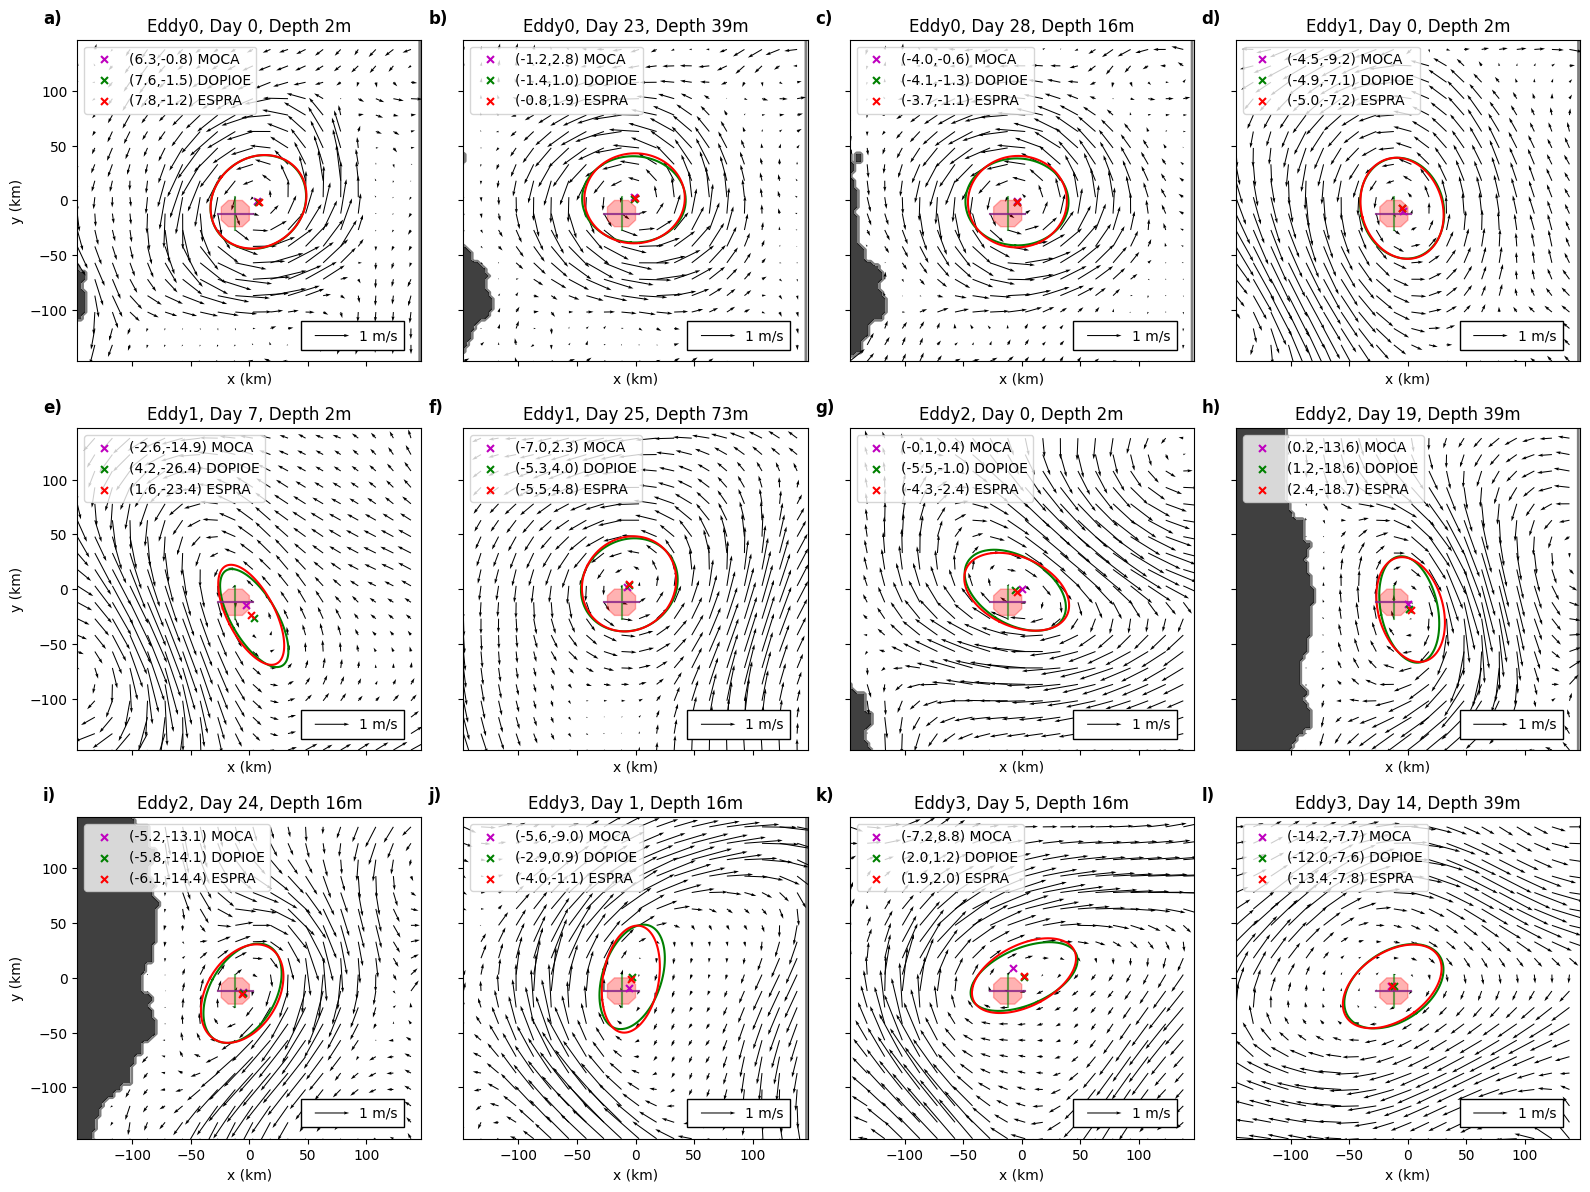

In [9]:
def int_to_excel(n):
    # Convert 0-indexed integer n to an Excel-style column label in lowercase
    n += 1  # Convert to 1-indexed
    result = ""
    while n:
        n, remainder = divmod(n - 1, 26)
        result = chr(97 + remainder) + result  # 97 is ASCII for 'a'
    return result

dfs = [df_MOCA_PAPER2, df_DOPIOE_PAPER2, df_ESPRA_PAPER2]

rows, cols = 3, 4

scale = 10
s = 25

fig, axs = plt.subplots(rows, cols, figsize=(16, 12), sharey=True, sharex=True)


for k in range(len(df_ESPRA_PAPER2)):

    for d, df in enumerate(dfs):
    
        ax = axs[k // cols, k % cols]
    
        df_rel = df.iloc[k]
        eddy, t, depth_lvl = df_rel['Eddy'], df_rel['Day'], df_rel['z']

        if d == 0:
            x_roms, y_roms = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
            X_roms, Y_roms, dx_roms = *np.meshgrid(x_roms, y_roms), x_roms[1]-x_roms[0]
            u_roms = sample_data[eddy]['T'+str(t)]['U'][:, :, depth_lvl]
            v_roms = sample_data[eddy]['T'+str(t)]['V'][:, :, depth_lvl]
            spacing = 5
            quiv = ax.quiver(X_roms[::spacing, ::spacing], Y_roms[::spacing, ::spacing], u_roms[::spacing, ::spacing].T, v_roms[::spacing, ::spacing].T, scale=scale)
        
        if df['Method'].iloc[0] == 'MOCA':

            df_rel = df_MOCA[(df_MOCA['Eddy']==eddy) & (df_MOCA['Day']==t) & (df_MOCA['z']==depth_lvl)]
        
            xc, yc, nic, njc, depth, w = df_rel['xc'].iloc[0], df_rel['yc'].iloc[0], df_rel['nic'], df_rel['njc'], df_rel['Depth'], df_rel['w']

            nic, njc = NIC, NJC
        
            # ax.plot(X_roms[nic, njc], Y_roms[nic, njc], marker='.', color='b')
            ax.plot([X_roms[nic, njc-r_roms], X_roms[nic, njc+r_roms]], [Y_roms[nic, njc-r_roms], Y_roms[nic, njc+r_roms]], 'm', zorder=4, alpha=0.6)
            
            ax.scatter(xc, yc, marker='x', s=s, color='m', zorder=4, label=f'({xc:.1f},{yc:.1f}) MOCA')
        
        if df['Method'].iloc[0] == 'DOPIOE':

            df_rel = df_DOPIOE[(df_DOPIOE['Eddy']==eddy) & (df_DOPIOE['Day']==t) & (df_DOPIOE['z']==depth_lvl)]
    
            xc, yc, nic, njc, depth, w, Q = df_rel['xc'].iloc[0], df_rel['yc'].iloc[0], df_rel['nic'], df_rel['njc'], df_rel['Depth'], df_rel['w'], df_rel['Q']

            nic, njc = NIC, NJC
            
            ax.plot([X_roms[nic-r_roms, njc], X_roms[nic+r_roms, njc]], [Y_roms[nic-r_roms, njc], Y_roms[nic+r_roms, njc]], 'g', zorder=3, alpha=0.6)
            ax.plot([X_roms[nic, njc-r_roms], X_roms[nic, njc+r_roms]], [Y_roms[nic, njc-r_roms], Y_roms[nic, njc+r_roms]], 'g', zorder=3, alpha=0.6)

            if not len(df_rel) == 0:
                ax.scatter(xc, yc, marker='x', s=s, color='g', zorder=4, label=f'({xc:.1f},{yc:.1f}) DOPIOE')

                Q = Q.iloc[0]
                x_ellipse, y_ellipse = plot_ellipse(Q, center=(xc, yc), scale=50)
                ax.plot(x_ellipse, y_ellipse, color='g')

        if df['Method'].iloc[0] == 'ESPRA':

            df_rel = df_ESPRA[(df_ESPRA['Eddy']==eddy) & (df_ESPRA['Day']==t) & (df_ESPRA['z']==depth_lvl)]

            xc, yc, nic, njc, depth, w, Q = df_rel['xc'].iloc[0], df_rel['yc'].iloc[0], df_rel['nic'], df_rel['njc'], df_rel['Depth'], df_rel['w'], df_rel['Q']
            
            nic, njc = NIC, NJC

            mask = (np.hypot(X_roms - X_roms[nic, njc], Y_roms - Y_roms[nic, njc]) < r_roms*dx_roms).T
            points = np.column_stack((X_roms[mask], Y_roms[mask]))
            
            if len(points) > 2:  # Convex hull requires at least 3 points
                hull = ConvexHull(points)
                ax.fill(points[hull.vertices, 0], points[hull.vertices, 1], color='r', alpha=0.3)

            if not len(df_rel) == 0:

                ax.scatter(xc, yc, marker='x', s=s, color='r', zorder=4, label=f'({xc:.1f},{yc:.1f}) ESPRA')

                Q = Q.iloc[0]
                x_ellipse, y_ellipse = plot_ellipse(Q, center=(xc, yc), scale=50)
                ax.plot(x_ellipse, y_ellipse, color='r')

        if d == 0:
            if np.any(np.isnan(u_roms)):
                nan_mask = np.isnan(u_roms)
                mask = np.where(~np.isnan(u_roms), np.nan, 0)
                ax.contourf(X_roms, Y_roms, mask.T, cmap='gray', zorder=-1)
                ax.contour(X_roms, Y_roms, nan_mask.T, colors='k', linewidths=2, alpha=.5)
        
            ax.set_title(f'Eddy{the_frontier_eddies.index(eddy)}, Day {t}, Depth {-round(z_r[depth_lvl])}m', fontsize=12)
        
        if d + k // cols == rows - 1:
            ax.set_xlabel('x (km)')
        if k % cols == 0:
            ax.set_ylabel('y (km)')

        if d == 0:
            ax.text(-0.1, 1.05, int_to_excel(k)+')', transform=ax.transAxes, fontsize=12, fontweight='bold')
 
    
        # ax.axis('equal')
        if d == 0:
            magnitude = 1
            x_pos, y_pos = 0.8, 0.08  
            box_width = 0.3 # Adjust width as needed
            box_height = 0.09  # Adjust height as needed
            rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                                   box_width, box_height, transform=ax.transAxes,
                                   facecolor='white', edgecolor='black')
            ax.add_patch(rect)
            ax.quiverkey(quiv, X=x_pos-.01, Y=y_pos, U=magnitude,
                         label=f'{magnitude} m/s', labelpos='E')

        ax.legend(loc='upper left')

plt.tight_layout()
plt.show()



In [10]:
df_DOPIOE

,Eddy,Day,xc,yc,nic,njc,z,Depth,w,Q,Rc,Scale
0,Eddy790,0,7.598018,-1.504123,45,45,0,-1.783320,0.034673,"[[0.009090791658762124, -0.0010904422247330688...",49.995590,2561.373471
1,Eddy790,0,6.854361,-0.357590,45,45,1,-5.879627,0.034472,"[[0.009082295096600494, -0.0011202280197565014...",49.999364,2561.370428
2,Eddy790,0,6.335782,0.116853,45,45,2,-10.725783,0.034225,"[[0.009015080497783184, -0.0011287797502227055...",49.999811,2568.453416
3,Eddy790,0,5.753414,0.343434,45,45,3,-16.383097,0.033981,"[[0.00893769053043012, -0.0011308084709039325]...",49.999917,2577.932997
4,Eddy790,0,5.040143,0.327330,45,45,4,-22.925581,0.033952,"[[0.008964637083446343, -0.00113064114421329],...",49.997792,2578.149362
...,...,...,...,...,...,...,...,...,...,...,...,...
2609,Eddy775,29,6.925475,-4.352308,45,45,17,-327.440851,-0.009481,"[[-0.0018072378819845372, -0.00102361776682180...",2.817163,7.934746
2610,Eddy775,29,8.120064,-4.993668,45,45,18,-407.922192,-0.008419,"[[-0.0015724014468417662, -0.00095509489508351...",2.669424,7.203156
2611,Eddy775,29,10.022308,-1.246542,45,45,19,-515.416489,-0.007298,"[[-0.0012774092822511085, -0.00040026697020883...",3.663305,13.146606
2612,Eddy775,29,7.881287,-3.088290,45,45,20,-660.806374,-0.006963,"[[-0.0012914524346971257, -0.00076325132607770...",2.700973,7.201820


In [11]:
df_DOPIOE['Eddy'].unique()

array(['Eddy790', 'Eddy110', 'Eddy134', 'Eddy775'], dtype=object)

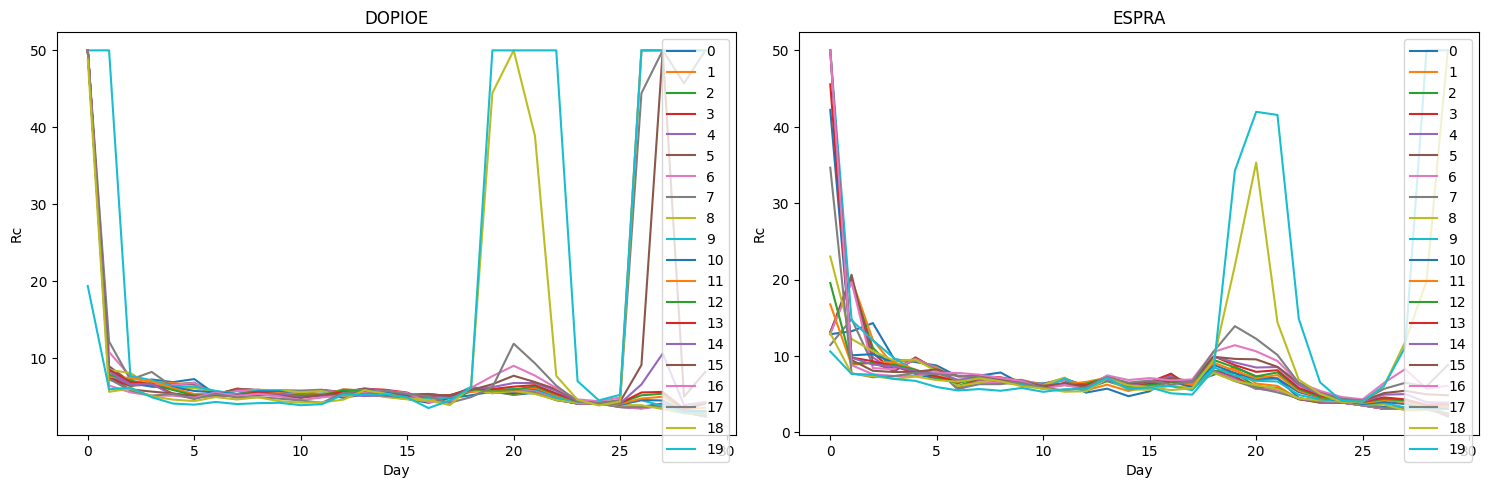

In [20]:

fig, axs = plt.subplots(1, 2, figsize=(15,5))
eddy = the_frontier_eddies[2]
for k in range(20):
    df = df_DOPIOE[(df_DOPIOE['Eddy']==eddy)&(df_DOPIOE['Depth']==z_r[k])]
    axs[0].plot(df['Day'], df['Rc'], label=k)
    axs[0].legend()
    axs[0].set_title('DOPIOE')
    axs[0].set_xlabel('Day')
    axs[0].set_ylabel('Rc')
    df = df_ESPRA[(df_ESPRA['Eddy']==eddy)&(df_ESPRA['Depth']==z_r[k])]
    axs[1].plot(df['Day'], df['Rc'], label=k)
    axs[1].legend()
    axs[1].set_title('ESPRA')
    axs[1].set_xlabel('Day')
    axs[1].set_ylabel('Rc')

plt.tight_layout()
plt.show()

In [13]:
# df = df_ESPRA[(df_ESPRA['Eddy']==eddy)&(df_ESPRA['Day']==9)]
# df = df.iloc[:-1]

df = df_DOPIOE[(df_DOPIOE['Eddy']==eddy)&(df_DOPIOE['Day']==9)]
df

,Eddy,Day,xc,yc,nic,njc,z,Depth,w,Q,Rc,Scale
2164,Eddy775,9,-7.972285,1.228771,45,45,0,-1.783320,-0.016889,"[[-0.0028278433107322932, -0.00089211184838064...",3.095396,9.550110
2165,Eddy775,9,-6.137545,-0.370298,45,45,1,-5.879627,-0.016746,"[[-0.0028181498975921124, -0.00097832094056892...",2.904980,8.491100
2166,Eddy775,9,-4.585757,-1.382646,45,45,2,-10.725783,-0.016637,"[[-0.0028061467864092682, -0.00105172735103947...",2.803321,8.000235
2167,Eddy775,9,-3.224704,-1.998978,45,45,3,-16.383097,-0.016454,"[[-0.0027628841446000305, -0.00113021849065782...",2.760721,7.867000
2168,Eddy775,9,-2.283333,-2.247119,45,45,4,-22.925581,-0.016246,"[[-0.0026883782792604845, -0.00118862821579702...",2.767855,7.993507
2169,Eddy775,9,-1.736365,-2.383911,45,45,5,-30.444118,-0.016133,"[[-0.0026543692055733445, -0.00126536187582183...",2.785967,8.150837
2170,Eddy775,9,-1.193052,-2.487486,45,45,6,-39.052712,-0.016051,"[[-0.0026137579076172877, -0.00126002772466255...",2.842423,8.504140
2171,Eddy775,9,-0.766138,-2.475363,45,45,7,-48.897638,-0.015871,"[[-0.002526937767923659, -0.001202160896971291...",2.948227,9.143288
2172,Eddy775,9,1.579747,-0.173248,45,45,8,-60.170639,-0.014415,"[[-0.0018820531917077374, -0.00059554764823217...",3.270861,11.398987
2173,Eddy775,9,-2.650215,0.265376,45,45,9,-73.127842,-0.015837,"[[-0.002041054257047395, -0.001250272881834273...",2.951695,8.934144


In [14]:
def gaussian_vel_reconstruction(x0, y0, q11, q12, q22, Rc, psi0):

    # q11, q22 = np.abs(q11), np.abs(q22)

    Q11 = - psi0 / Rc**2 * q11
    Q12 = - psi0 / Rc**2 * q12
    Q22 = - psi0 / Rc**2 * q22

    # Q11 = q11
    # Q12 = q12
    # Q22 = q22
    
    width = 200
    x = np.linspace(x0-width, x0+width, 51)
    y = np.linspace(y0-width, y0+width, 51)
    X, Y = np.meshgrid(x, y)
    
    dx, dy = X - x0, Y - y0
    
    phi   = Q11*dx**2 + 2*Q12*dx*dy + Q22*dy**2
    phi_x = 2*Q11*dx  + 2*Q12*dy
    phi_y = 2*Q22*dy  + 2*Q12*dx
    
    # 5) build Gaussian streamfunction with that R
    exp_term = np.exp(-phi / Rc**2)
    psi_x = -phi_x / Rc**2 * exp_term
    psi_y = -phi_y / Rc**2 * exp_term
    
    u = -psi_y * psi0
    v =  psi_x * psi0

    return u, v, X, Y


dic = {}
for k in df['z']:
    dic[f'z{k}'] = {}
    data = df[df['z']==k]
    Q = data.iloc[0].Q
    q11e = Q[0,0]
    q12e = Q[0,1]
    q22e = Q[1,1]
    x0e = data.iloc[0].xc
    y0e = data.iloc[0].yc
    Depthe = -data.iloc[0].Depth
    Rce = data.iloc[0].Rc
    scale_opt = data.iloc[0].Scale

    u_dopioe, v_dopioe, X_dopioe, Y_dopioe = gaussian_vel_reconstruction(x0e, y0e, q11e, q12e, q22e, Rce, scale_opt)
    dic[f'z{k}']['u'] = u_dopioe
    dic[f'z{k}']['v'] = v_dopioe
    dic[f'z{k}']['X'] = X_dopioe
    dic[f'z{k}']['Y'] = Y_dopioe
    dic[f'z{k}']['Depth'] = -z_r[k]
    

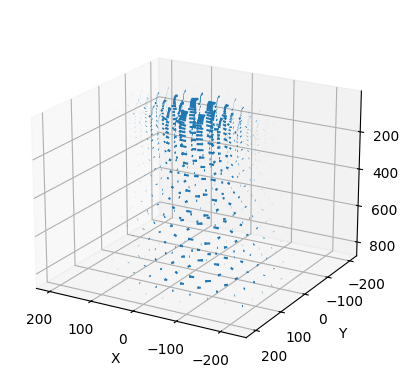

In [15]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

spacing = 5
scale_factor = 100  # adjust arrow length

for key in dic:
    d = dic[key]
    XX = d['X'][::spacing, ::spacing]
    YY = d['Y'][::spacing, ::spacing]
    ZZ = d['Depth']*np.ones(XX.shape)
    UU = d['u'][::spacing, ::spacing] * scale_factor
    VV = d['v'][::spacing, ::spacing] * scale_factor
    WW = np.zeros_like(UU)

    ax.quiver(XX, YY, ZZ, UU, VV, WW)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Depth')
ax.invert_zaxis()
ax.view_init(elev=20, azim=120)

plt.show()


In [16]:
import numpy as np
from scipy.interpolate import griddata

# 1) collect all (x,y,z) points and their u,v values
pts = []
uvals = []
vvals = []
for d in dic.values():
    X = d['X'].ravel()
    Y = d['Y'].ravel()
    Z = d['Depth'] * np.ones_like(X)
    pts.append(np.column_stack((X, Y, Z)))
    uvals.append((d['u'] * scale_factor).ravel())
    vvals.append((d['v'] * scale_factor).ravel())

pts   = np.vstack(pts)
uvals = np.concatenate(uvals)
vvals = np.concatenate(vvals)

# 2) choose your new grid resolution
nz = len(dic)
ny = max(d['X'].shape[0] for d in dic.values()) // 2
nx = max(d['X'].shape[1] for d in dic.values()) // 2

xi = np.linspace(pts[:,0].min(), pts[:,0].max(), nx)
yi = np.linspace(pts[:,1].min(), pts[:,1].max(), ny)
zi = np.linspace(pts[:,2].min(), pts[:,2].max(), nz)
# zi = -z_r[:np.sort([int(a[1:]) for a in dic.keys()]).max()+1]

Xg, Yg, Zg = np.meshgrid(xi, yi, zi, indexing='xy')
grid_pts   = np.column_stack((Xg.ravel(), Yg.ravel(), Zg.ravel()))

# 3) interpolate onto the cube
U = griddata(pts, uvals, grid_pts, method='linear', fill_value=0)
V = griddata(pts, vvals, grid_pts, method='linear', fill_value=0)
# W = np.zeros_like(U)

# 4) reshape back to 3D
U = U.reshape(Xg.shape)
V = V.reshape(Xg.shape)
# W = W.reshape(Xg.shape)


KeyboardInterrupt: 

In [ ]:
def solve_w(U, V, x, y, z, f=-7.7e-5, N2=5e-3):
    # tic = time.time()

    x = x * 1000
    y = y * 1000
    # z = z * 1000

    dx, dy, dz = x[1] - x[0], y[1] - y[0], z[1] - z[0]
    nx, ny, nz = U.shape

    # build Q
    dudz = np.gradient(U, dz, axis=2)
    dvdz = np.gradient(V, dz, axis=2)
    dvdx = np.gradient(V, dx, axis=0)
    dvdy = np.gradient(V, dy, axis=1)
    dudx = np.gradient(U, dx, axis=0)
    dudy = np.gradient(U, dy, axis=1)

    Qx =  f * (dudz * dvdx + dvdz * dvdy)
    Qy = -f * (dudz * dudx + dvdz * dudy)

    S = 2 * (np.gradient(Qx, dx, axis=0) + np.gradient(Qy, dy, axis=1))
    b = S.ravel(order='F')

    # finite difference operators
    ex, ey = np.ones(nx), np.ones(ny)
    Lx = diags([ex, -2*ex, ex], [-1, 0, 1], shape=(nx, nx)) / dx**2
    Ly = diags([ey, -2*ey, ey], [-1, 0, 1], shape=(ny, ny)) / dy**2
    Ix, Iy = eye(nx), eye(ny)

    # nonuniform Lz
    Lz = np.zeros((nz, nz))
    for i in range(1, nz - 1):
        dzm = z[i] - z[i - 1]
        dzp = z[i + 1] - z[i]
        Lz[i, i - 1] =  2 / (dzm * (dzm + dzp))
        Lz[i, i]     = -2 / (dzm * dzp)
        Lz[i, i + 1] =  2 / (dzp * (dzm + dzp))
    Lz = csr_matrix(Lz)
    Iz = eye(nz)

    A = N2 * (kron(kron(Iz, Iy), Lx) + kron(kron(Iz, Ly), Ix)) \
      + f**2 * kron(kron(Lz, Iy), Ix)

    w = spsolve(A.tocsr(), b).reshape((nx, ny, nz), order='F')

    # toc = time.time()
    # print(f"Elapsed time: {toc - tic:.4f} seconds")

    return w
    

In [ ]:
from scipy.sparse import diags, eye, kron, csr_matrix
from scipy.sparse.linalg import spsolve

W = solve_w(U, V, xi, yi, zi)


In [ ]:
fig, axs = plt.subplots(6, 4, figsize=(15, 15))
for p in range(W.shape[-1]):
    ax = axs[p // 4, p % 4]
    cf = ax.contourf(xi, yi, W[:, :, p] * 86400 )
    ax.axis('equal')
    ax.set_title(f'Depth {round(zi[p])}m')
    fig.colorbar(cf, ax=ax, label=r'm Day$^{-1}$')
plt.tight_layout()
plt.show()


### $\sigma_{OW}$

In [ ]:
def calc_ow(uu, vv, dx, dy, flag=True):
    WIDTH, LENGTH, SIGMAS = uu.shape

    if flag:
        for k in range(SIGMAS):
            uu[:,:,k] = uu[:,:,k].T
            vv[:,:,k] = vv[:,:,k].T
    
    u_x = (uu[2:,:,:] - uu[:-2,:,:]) / (2*dx)
    u_y = (uu[:,2:,:] - uu[:,:-2,:]) / (2*dy)
    v_x = (vv[2:,:,:] - vv[:-2,:,:]) / (2*dx)
    v_y = (vv[:,2:,:] - vv[:,:-2,:]) / (2*dy)
    u_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), u_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    v_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), v_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    u_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), u_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    v_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), v_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    s_n = u_x - v_y
    s_s = v_x + u_y
    vort = v_x - u_y
    ow = s_n**2 + s_s**2 - vort**2
    return ow
    
def normalize_matrix(matrix, mask_value=np.nan):
    valid_mask = np.where(matrix == mask_value, 0, 1)
    valid_mean = np.nansum(matrix) / np.sum(valid_mask)
    valid_std = np.sqrt(np.nansum(valid_mask * (matrix - valid_mean) ** 2) / np.sum(valid_mask))
    return (matrix - valid_mean) / valid_std


In [ ]:
dx = np.diff(xi)[0]
dy = np.diff(yi)[0]

ow = calc_ow(U, V, dx*1000, dy*1000)
sigma_ow = normalize_matrix(ow)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes
from scipy.ndimage import map_coordinates

# ---- assume you already have ----
# sigma_ow : 3D numpy array of your scalar field
# Xg, Yg, Zg : 3D numpy arrays (same shape as sigma_ow)
# ---------------------------------

# 1. extract isosurface in index-space
verts, faces, normals, values = marching_cubes(sigma_ow, level=-0.2)

# 2. map each index‐space vertex into your real-world coords
#    verts is (Nverts, 3), columns = (i, j, k)
#    map_coordinates expects coordinates as (dim, Npoints)
pts = verts.T  # shape (3, Nverts)

# interpolate each coordinate array at those fractional indices
real_x = map_coordinates(Xg, pts, order=1)
real_y = map_coordinates(Yg, pts, order=1)
real_z = map_coordinates(Zg, pts, order=1)

# stack back into (Nverts, 3)
real_verts = np.vstack((real_x, real_y, real_z)).T

# 3. plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

mesh = Poly3DCollection(real_verts[faces], alpha=0.3)
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

# # optionally plot quiver of your velocity vectors (downsampled)
# step = 5
# ax.quiver(
#     Xg[::step,::step,::step],
#     Yg[::step,::step,::step],
#     Zg[::step,::step,::step],
#     U[::step,::step,::step],  # replace Ui, Vi, Wi with your vector components
#     V[::step,::step,::step],
#     W[::step,::step,::step],
#     length=10, normalize=True,  # adjust as needed
#     linewidths=0.5
# )

# 4. set axes limits to the extents of your grid
ax.set_xlim(Xg.min(), Xg.max())
ax.set_ylim(Yg.min(), Yg.max())
ax.set_zlim(Zg.min(), Zg.max())

# if you still want z inverted:
ax.invert_zaxis()

ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
ax.set_zlabel('Depth (m)')

plt.tight_layout()
plt.show()